# Get Galaxies From Halos

info: https://cdcvs.fnal.gov/redmine/projects/des-clusters/wiki/ClustDataVecY3 <br>
path: /data/des81.b/data/mariaeli/y3_buzz/Buzzard-3_v2.0_Y3a_mastercat/

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, vstack
from astropy.io.fits import getdata

import pandas as pd
import healpy as hp

import esutil

## Load

In [2]:
import h5py

path   = '/data/des81.b/data/mariaeli/y3_buzz/Buzzard-3_v2.0_Y3a_mastercat/'
# path   = '/global/project/projectdirs/des/jderose/Chinchilla/Herd/Chinchilla-3/v1.9.8/sampleselection/Y3a/mastercat/'
fname  = path+'Buzzard_v2.0_Y3a_gold.h5'
fname_bpz = path+'Buzzard_v2.0_Y3a_bpz.h5'
fname_aux  = path+'Buzzard-3_v2.0_Y3a_mastercat.h5'

master = h5py.File(fname,'r')
indexes= h5py.File(fname_aux,'r')

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
!ls /data/des81.b/data/mariaeli/y3_buzz/Buzzard-3_v2.0_Y3a_mastercat/

buzzard_1.9.9_3y3a_rsshift_run.h5  Buzzard_v2.0_Y3a_gold.h5
Buzzard-3_v2.0_Y3a_mastercat.h5    Buzzard_v2.0_Y3a_shape.h5
Buzzard_v2.0_Y3a_bpz.h5		   nohup.out


In [4]:
def show_h5_group(name,node):
    ''' show all the h5 groups
    Example:
    fmaster = h5py.File(copa.master_fname,'r')
    fmaster.visititems(show_h5_group)

    ## https://stackoverflow.com/questions/45562169/traverse-hdf5-file-tree-and-continue-after-return
    '''
    if isinstance(node, h5py.Group):
        print(name,node)
    return None

def show_h5_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name,node)
    return None

In [5]:
columns = ['hpix_16384','haloid','coadd_object_id','ra','dec','rhalo']
columns+= ['mag_%s'%(ix) for ix in ['g','r','i','z']]
columns+= ['mag_err_%s'%(ix) for ix in ['g','r','i','z']]

In [6]:
columns

['hpix_16384',
 'haloid',
 'coadd_object_id',
 'ra',
 'dec',
 'rhalo',
 'mag_g',
 'mag_r',
 'mag_i',
 'mag_z',
 'mag_err_g',
 'mag_err_r',
 'mag_err_i',
 'mag_err_z']

In [7]:
master.visititems(show_h5_dataset)

(u'catalog/gold/coadd_object_id', <HDF5 dataset "coadd_object_id": shape (1504210222,), type ">i8">)
(u'catalog/gold/dec', <HDF5 dataset "dec": shape (1504210222,), type ">f4">)
(u'catalog/gold/flags_gold', <HDF5 dataset "flags_gold": shape (1504210222,), type ">i8">)
(u'catalog/gold/flux_g', <HDF5 dataset "flux_g": shape (1504210222,), type ">f4">)
(u'catalog/gold/flux_i', <HDF5 dataset "flux_i": shape (1504210222,), type ">f4">)
(u'catalog/gold/flux_r', <HDF5 dataset "flux_r": shape (1504210222,), type ">f4">)
(u'catalog/gold/flux_z', <HDF5 dataset "flux_z": shape (1504210222,), type ">f4">)
(u'catalog/gold/haloid', <HDF5 dataset "haloid": shape (1504210222,), type ">i8">)
(u'catalog/gold/hpix_16384', <HDF5 dataset "hpix_16384": shape (1504210222,), type ">i8">)
(u'catalog/gold/ivar_g', <HDF5 dataset "ivar_g": shape (1504210222,), type ">f4">)
(u'catalog/gold/ivar_i', <HDF5 dataset "ivar_i": shape (1504210222,), type ">f4">)
(u'catalog/gold/ivar_r', <HDF5 dataset "ivar_r": shape (150

In [8]:
indexes['index'].visititems(show_h5_dataset)

(u'bpz/match_gold', <HDF5 dataset "match_gold": shape (1504210222,), type "<i8">)
(u'bpz/select', <HDF5 dataset "select": shape (1504210222,), type "<i8">)
(u'coadd_object_id', <HDF5 dataset "coadd_object_id": shape (1504210222,), type "<i8">)
(u'gold/select', <HDF5 dataset "select": shape (1504210222,), type "<i8">)
(u'maglim/select', <HDF5 dataset "select": shape (2388988,), type "<i8">)
(u'mask/fracgood', <HDF5 dataset "fracgood": shape (21590657,), type "<i8">)
(u'mask/hpix', <HDF5 dataset "hpix": shape (21590657,), type "<i8">)
(u'mask/zmax', <HDF5 dataset "zmax": shape (21590657,), type "<i8">)
(u'metacal/match_gold', <HDF5 dataset "match_gold": shape (1504210222,), type "<i8">)
(u'redmagic/combined_sample_fid/match_gold', <HDF5 dataset "match_gold": shape (3041935,), type "<i8">)
(u'redmagic/combined_sample_fid/random_10xdownsample_select', <HDF5 dataset "random_10xdownsample_select": shape (30419350,), type "<i8">)
(u'redmagic/combined_sample_fid/random_select', <HDF5 dataset "

In [9]:
select     = indexes['index/gold/select'][:]
mag_i      = master['catalog/gold/mag_i'][:][select]

## please change here, I did for mag limited sample just to make things faster
maglim_idx = select[np.where(mag_i<=17.)]

ra   = master['catalog/gold/ra'][:][maglim_idx]
dec   = master['catalog/gold/dec'][:][maglim_idx]

select=mag_i=0

master.close()
indexes.close()

## Query GW Sky Map

In [10]:
fname = '/data/des70.b/data/palmese/bayestar-sims/HLVK_O4/bns/fits/flatten/845.fits.gz'
hpx_map = Table(getdata(fname))

In [11]:
hpx_map

PROB,DISTMU,DISTSIGMA,DISTNORM
float64,float64,float64,float64
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407
1.5713738532000388e-14,53.262045194654014,4.295338478404799,0.00035022646103991407


In [12]:
hpx = np.array(hpx_map['PROB'])

In [13]:
i = np.flipud(np.argsort(hpx))
sorted_credible_levels = np.cumsum(hpx[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels
hpx_90percent, = np.where(credible_levels <= 0.9)

In [14]:
print('# pix: %i'%(credible_levels.size))

# pix: 50331648


In [16]:
nside = 16384
for i in range(1,10):
    factor = 2*i
    print('Nside, Npix: %i, %i'%(nside/factor,hp.nside2npix(nside/factor)))

Nside, Npix: 8192, 805306368
Nside, Npix: 4096, 201326592
Nside, Npix: 2730, 89434800
Nside, Npix: 2048, 50331648
Nside, Npix: 1638, 32196528
Nside, Npix: 1365, 22358700
Nside, Npix: 1170, 16426800
Nside, Npix: 1024, 12582912
Nside, Npix: 910, 9937200


In [17]:
## Degrade Buzzard Map
nside_gw = 2048
npix = hp.nside2npix(nside_gw)
    
thetas,phis = np.radians(90-dec),np.radians(ra)

# Go from radec to HEALPix coordinates 
hpx2048 = hp.ang2pix(nside_gw, thetas, phis, nest=True)

hpxmap = np.zeros(npix, dtype=np.float)
w, values = np.unique(hpx2048,return_counts=True)
hpxmap[w] = values

## Plot Maps

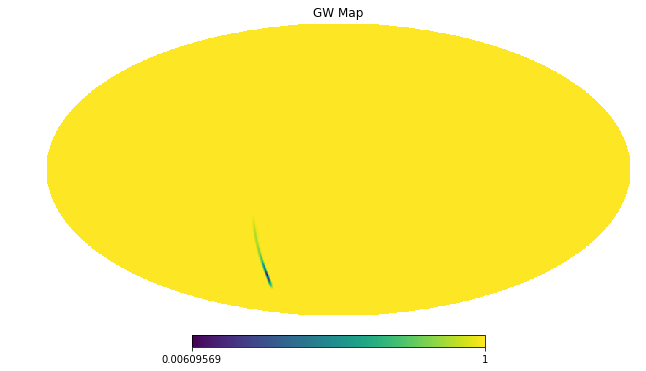

In [18]:
import healpy as hp
hp.mollview(credible_levels, nest=True, title="GW Map")

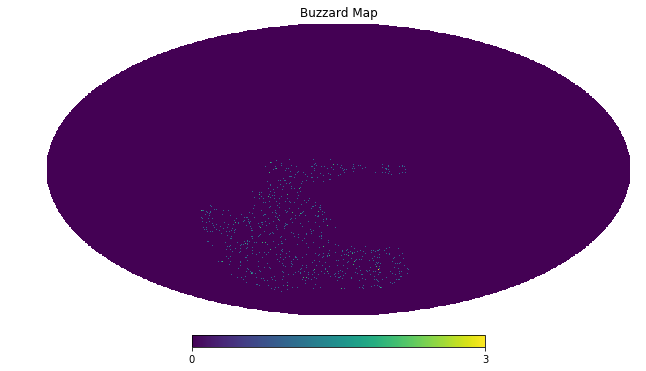

In [19]:
hp.mollview(hpxmap, nest=True, title="Buzzard Map")

## Healpix Matching

In [20]:
hpx_90percent

array([33930176, 33930177, 33930178, ..., 35389309, 35389310, 35389311])

In [21]:
match  = esutil.numpy_util.match(hpx_90percent,hpx2048)
indices= maglim_idx[match[1]]

In [22]:
1.*match[1].size/hpx2048.size

0.008673531111798152

In [23]:
1.*match[0].size/hpx_90percent.size

0.04485887096774194

## Querying matched sample

In [24]:
def load_hdf_files(infile,indices,columns,path='catalog/gold/'):
    master = h5py.File(infile,'r')
    gold   = master[path]
    
    mydict = dict().fromkeys(columns)
    for col in columns:
        mydict[col] = gold[col][:][indices]
    
    master.close()
    return Table(mydict)

In [27]:
fname  = path+'Buzzard_v2.0_Y3a_gold.h5'
data = load_hdf_files(fname,indices,columns,path='catalog/gold/')

In [28]:
fname_bpz = path+'Buzzard_v2.0_Y3a_bpz.h5'
zdata = load_hdf_files(fname_bpz,indices,['coadd_object_id','z'],path='catalog/bpz/')

In [29]:
data

mag_err_i,mag_g,mag_err_r,mag_r,mag_i,hpix_16384,mag_err_z,ra,haloid,coadd_object_id,dec,rhalo,mag_err_g,mag_z
float32,float32,float32,float32,float32,int64,float32,float32,int64,int64,float32,float32,float32,float32
0.002681993,17.94115,0.0024353066,16.998877,16.5778,2171531353,0.0026841834,69.79563,9750594,57006545937,-64.52653,0.0,0.0036970421,16.294415
0.0030265478,18.343966,0.0028363585,17.32179,16.8747,2171531607,0.0031541064,69.8445,9750594,57006549153,-64.47845,0.3475223,0.004895578,16.554644
0.003522672,18.305492,0.0031305433,17.301388,16.932566,2171535088,0.003939595,69.41006,9752167,57006546523,-64.26516,0.0,0.005480098,16.664116
0.0021868453,17.168234,0.0017280267,16.539192,16.200027,2171568580,0.0028754324,70.42767,9728647,57006547566,-64.47195,3.407616,0.0024070023,16.041061
0.0030165454,18.19981,0.0027153122,17.250586,16.810488,2171568777,0.0031162095,70.22746,9728647,57006552129,-64.490364,0.047017217,0.0044564456,16.5045
0.0013674889,16.454388,0.0012055134,15.489852,15.095932,2171568781,0.001427935,70.23299,9728647,57006546590,-64.486786,0.11734714,0.001984661,14.8119
0.00347399,17.78561,0.0027369456,17.151419,16.842594,2171569562,0.0051182425,70.46062,9710497,57006556315,-64.38727,0.9927234,0.0032103844,16.665594
0.0025402359,17.510138,0.0021115523,16.591755,16.169859,2171569566,0.003529099,70.46184,9710497,57006551101,-64.38088,0.69780713,0.0028250373,15.872665
0.0028700344,17.78906,0.0024866092,16.830118,16.47471,2171570311,0.0037996469,70.11174,9754521,57006547126,-64.44099,3.5582654,0.0037674264,16.225582


In [30]:
zdata

coadd_object_id,z
int64,float64
57006545937,0.12781614969080124
57006549153,0.1267228163711511
57006546523,0.13118181037744975
57006547566,0.10550755577890893
57006552129,0.10518850258559409
57006546590,0.10399139464955462
57006556315,0.0844583778833553
57006551101,0.08406815840508375
57006547126,0.12994835710685662
